In [56]:
import psycopg2
import pandas as pd
import numpy as np
import networkx as nx

In [57]:
# connect to database
conn = psycopg2.connect(
    host="localhost",
    port=5450,
    database="postgres",
    user="postgres",
    password="postgres"
)

# create cursor
cur = conn.cursor()

In [58]:
weights = {
    'headtosub': 2,
    'headtopara': 1,
}

# normalize weights
weights = {k: v / sum(weights.values()) for k, v in weights.items()}
print(weights)

{'headtosub': 0.6666666666666666, 'headtopara': 0.3333333333333333}


In [59]:
# get the topics_preprocessed column from the topics table where it is not "" and topics_preprocessed is unique
cur.execute("""
    SELECT DISTINCT topics_preprocessed, idf
    FROM topics
    WHERE topics_preprocessed != ''
""")
topics_preprocessed = cur.fetchall()

# make a dataframe from the topics_preprocessed column
df = pd.DataFrame(topics_preprocessed, columns=['topics', 'idf'])

In [60]:
len(df)

59521

In [61]:
df.head()

,topics,idf
0,cma,9.508152446764088
1,state legislatures,10.201299627324033
2,create a movement,10.201299627324033
3,california consumer privacy protection,10.201299627324033
4,network security consultant,10.201299627324033


In [62]:
df.tail()

,topics,idf
59516,phased approach,10.201299627324033
59517,classificationbased data discovery tools,10.201299627324033
59518,recover objects,10.201299627324033
59519,moving within the cloud,10.201299627324033
59520,deprovisioning access,10.201299627324033


In [63]:
# initialize graph, mono-directional
G = nx.DiGraph()

In [64]:
import tqdm

# for each topic in the dataframe, add a node to the graph
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    G.add_node(row['topics'], idf=row['idf'])

100%|██████████████████████████████████| 59521/59521 [00:03<00:00, 16454.55it/s]


In [65]:
# display 5 random nodes, with their properties
for node in np.random.choice(G.nodes, 5):
    print(node, G.nodes[node])

reportin {'idf': Decimal('10.201299627324033')}
distributed filesystem team {'idf': Decimal('10.201299627324033')}
security community {'idf': Decimal('10.201299627324033')}
tech community {'idf': Decimal('10.201299627324033')}
protection regulation {'idf': Decimal('10.201299627324033')}


In [66]:
# get the url, next_heading, subheading, heading_topics and content_topics columns from the resources table
cur.execute("""
    SELECT id, url, hnum, next_heading, subheading, heading_topics, content_topics
    FROM resources
""")
resources = cur.fetchall()

# make a dataframe from the resources table
df = pd.DataFrame(resources, columns=['id', 'url', 'hnum', 'next_heading', 'subheading', 'heading_topics', 'content_topics'])

len(df)

9909

In [67]:
df.head()

,id,url,hnum,next_heading,subheading,heading_topics,content_topics
0,5,https://adaptive.live/blog/rethink-infrastruct...,4,NaN,5.0,"[remotefirst, trend]","[2020, covid, and, remote, work, mainstream, t..."
1,4,https://adaptive.live/blog/rethink-infrastruct...,3,4.0,8.0,"[complexity, infrastructure, modernday infrast...","[order, understand, problems, infrastructure, ..."
2,8,https://adaptive.live/blog/understanding-sox-c...,10,11.0,15.0,"[benefits, sox, compliance, sox compliance]","[all, companies, obliged, comply, sox, what, b..."
3,15,https://adaptive.live/blog/rethink-infrastruct...,12,13.0,16.0,"[limitations, existing, solutions, existing so...","[infrastructure, access, management, platform,..."
4,16,https://adaptive.live/blog/rethink-infrastruct...,13,NaN,14.0,"[vpns, obsolete]","[vpn, ubiquitous, and, organization, uses, vpn..."


In [68]:
# make hnum, next_heading and subheading columns to integers, if nan, make it -1
df['hnum'] = df['hnum'].fillna(-1).astype(int)
df['next_heading'] = df['next_heading'].fillna(-1).astype(int)
df['subheading'] = df['subheading'].fillna(-1).astype(int)

In [69]:
df.head()

,id,url,hnum,next_heading,subheading,heading_topics,content_topics
0,5,https://adaptive.live/blog/rethink-infrastruct...,4,-1,5,"[remotefirst, trend]","[2020, covid, and, remote, work, mainstream, t..."
1,4,https://adaptive.live/blog/rethink-infrastruct...,3,4,8,"[complexity, infrastructure, modernday infrast...","[order, understand, problems, infrastructure, ..."
2,8,https://adaptive.live/blog/understanding-sox-c...,10,11,15,"[benefits, sox, compliance, sox compliance]","[all, companies, obliged, comply, sox, what, b..."
3,15,https://adaptive.live/blog/rethink-infrastruct...,12,13,16,"[limitations, existing, solutions, existing so...","[infrastructure, access, management, platform,..."
4,16,https://adaptive.live/blog/rethink-infrastruct...,13,-1,14,"[vpns, obsolete]","[vpn, ubiquitous, and, organization, uses, vpn..."


In [70]:
# def call_related_headings(headingid, headings, listofrelatedids=None, nextheading=False):
#     print(headingid, nextheading, listofrelatedids)
#     if listofrelatedids is None:
#         listofrelatedids = []
#     if not nextheading:
#         # if headings.iloc[headingid]['subheading'] is not nan (nan is class numpy.float64)
#         if pd.isna(headings.iloc[headingid]['subheading'])==False:
#             # subheadingid is then the index of row with url the sameas the headingid and hnum the same as headings.iloc[headingid]['subheading']
#             subheadingid = headings[(headings['url']==headings.iloc[headingid]['url']) & (headings['hnum']==int(headings.iloc[headingid]['subheading']))].index[0]
#             listofrelatedids.append(subheadingid)
#             listofrelatedids = call_related_headings(subheadingid, headings, listofrelatedids, True)
#     if nextheading:
#         if pd.isna(headings.iloc[headingid]['next_heading'])==False:
#             nextheadingid = headings[(headings['url']==headings.iloc[headingid]['url']) & (headings['hnum']==int(headings.iloc[headingid]['next_heading']))].index[0]
#             listofrelatedids.append(nextheadingid)
#             listofrelatedids = call_related_headings(nextheadingid, headings, listofrelatedids, True)
#     return listofrelatedids

# the next_heading and the sub_heading columns are swapped because of a mistake in the database
def call_related_headings(headingid, headings, listofrelatedids=None, nextheading=False):
    if listofrelatedids is None:
        listofrelatedids = []
    if not nextheading:
        # if there is a subheading
        # hnum = headings.iloc[headingid]['hnum']
        if headings.iloc[headingid]['next_heading']!=-1:
            url = headings.iloc[headingid]['url']
            subid = headings.iloc[headingid]['next_heading']
            subheadingid = headings[(headings['url']==url) & (headings['hnum']==subid)]
            subheadingid = subheadingid.index[0]
            listofrelatedids.append(subheadingid)
            listofrelatedids = call_related_headings(subheadingid, headings, listofrelatedids=listofrelatedids, nextheading=True)
    if nextheading:
        if headings.iloc[headingid]['subheading']!=-1:
            url = headings.iloc[headingid]['url']
            nextid = headings.iloc[headingid]['subheading']
            nextheadingid = headings[(headings['url']==url) & (headings['hnum']==nextid)]
            nextheadingid = nextheadingid.index[0]
            listofrelatedids.append(nextheadingid)
            listofrelatedids = call_related_headings(nextheadingid, headings, listofrelatedids=listofrelatedids, nextheading=True)
    return listofrelatedids

In [71]:
# get index of heading row where 'id' is 1
idx = df[df['url'] == 'https://adaptive.live/blog/rethink-infrastructure-access']
idx

,id,url,hnum,next_heading,subheading,heading_topics,content_topics
0,5,https://adaptive.live/blog/rethink-infrastruct...,4,-1,5,"[remotefirst, trend]","[2020, covid, and, remote, work, mainstream, t..."
1,4,https://adaptive.live/blog/rethink-infrastruct...,3,4,8,"[complexity, infrastructure, modernday infrast...","[order, understand, problems, infrastructure, ..."
3,15,https://adaptive.live/blog/rethink-infrastruct...,12,13,16,"[limitations, existing, solutions, existing so...","[infrastructure, access, management, platform,..."
4,16,https://adaptive.live/blog/rethink-infrastruct...,13,-1,14,"[vpns, obsolete]","[vpn, ubiquitous, and, organization, uses, vpn..."
920,10,https://adaptive.live/blog/rethink-infrastruct...,7,-1,-1,"[security, security by obscurity]","[organizations, organization, infrastructure, ..."
922,7,https://adaptive.live/blog/rethink-infrastruct...,6,-1,7,"[compliance, audits, enforce, better, security...","[compliance, audits, soc2, iso, hipaa, and, so..."
928,12,https://adaptive.live/blog/rethink-infrastruct...,9,-1,10,"[problem, privilege, abuse, privilege abuse]","[how, times, you, organizations, everyone, acc..."
937,19,https://adaptive.live/blog/rethink-infrastruct...,15,-1,-1,"[existing, access, management, tools, too, exp...","[existing, infrastructure, access, management,..."
938,20,https://adaptive.live/blog/rethink-infrastruct...,16,-1,17,[adaptive],"[order, solve, gaps, market, we, built, adapti..."
3805,2,https://adaptive.live/blog/rethink-infrastruct...,1,-1,2,"[increasing, data, breach, problem, data breac...","[problem, cyber, breaches, worse, day, best, w..."


In [72]:
call_related_headings(2, df)

[933, 939, 3816, 8]

In [73]:
# for each heading in the dataframe, call the call_related_headings function
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    try:
        related_headings = call_related_headings(i, df)
    except:
        continue
    # for each related heading
    for heading in related_headings:
        # if the heading is not the same as the row
        for topic in row['heading_topics']:
            for related_topic in df.iloc[heading]['heading_topics']:
                if not G.has_edge(topic, related_topic):
                    G.add_edge(topic, related_topic, weight=weights['headtosub'])
                else:
                    G.edges[topic, related_topic]['weight'] += weights['headtosub']

  0%|                                                  | 0/9909 [00:00<?, ?it/s]

100%|██████████████████████████████████████| 9909/9909 [00:18<00:00, 522.61it/s]


In [74]:
# # for each row in df, iterate over the heading_topics
for i, row in tqdm.tqdm(df.iterrows(), total=len(df)):
    # get the heading_topics
    heading_topics = row['heading_topics']
    for htop in heading_topics:
        # get the column_topics
        column_topics = row['content_topics']
        for ctop in column_topics:
            # add an edge from the heading_topics to the column_topics if the edge does not already exist
            if not G.has_edge(htop, ctop):
                G.add_edge(htop, ctop, weight=weights['headtopara'])
            else:
                G.edges[htop, ctop]['weight'] += weights['headtopara']

# normalize weights
# for u, v, d in G.edges(data=True):
#     d['weight'] /= G.out_degree(u)

# display 5 random edges, with their properties
# for u, v in np.random.choice(G.edges, 5):
#     print(u, v, G.edges[u, v])

# print the first 5 edges
list(G.edges(data=True))[:5]

100%|█████████████████████████████████████| 9909/9909 [00:07<00:00, 1275.63it/s]


[('create a movement', 'ccpa', {'weight': 1.3333333333333333}),
 ('create a movement', 's', {'weight': 1.6666666666666665}),
 ('create a movement', 'popularity', {'weight': 0.3333333333333333}),
 ('create a movement', 'california', {'weight': 0.3333333333333333}),
 ('create a movement', 'residents', {'weight': 0.3333333333333333})]

In [75]:
# perform pagerank on the graph, with node weights as the idf, and edge weights as the weights defined above
pagerank = nx.pagerank(G, alpha=0.85, weight='weight')

# print the first 5 pageranks
list(pagerank.items())[:5]

[('cma', 1.2258984531587136e-05),
 ('state legislatures', 1.3011818233812195e-05),
 ('create a movement', 1.3003344885910769e-05),
 ('california consumer privacy protection', 1.233582827226852e-05),
 ('network security consultant', 1.2184052730940156e-05)]

In [76]:
# add the pagerank to the graph
nx.set_node_attributes(G, pagerank, 'pagerank')

# display 5 random nodes, with their properties
for node in np.random.choice(G.nodes, 5):
    print(node, G.nodes[node])

user errors {'idf': Decimal('10.201299627324033'), 'pagerank': 1.2567865424684074e-05}
internal security tool {'idf': Decimal('10.201299627324033'), 'pagerank': 1.2803203608717644e-05}
recent new hires {'idf': Decimal('10.201299627324033'), 'pagerank': 1.2727122886594542e-05}
devsecops security statistics {'idf': Decimal('10.201299627324033'), 'pagerank': 1.2328310368842488e-05}
equipment maintenance {'idf': Decimal('10.201299627324033'), 'pagerank': 1.2184052730940156e-05}


In [77]:
# display top 5 connected nodes based on a given node based on the pagerank
def get_top_nodes(node_name, n=2):
    # get the node
    node = G.nodes[node_name]
    # get the edges
    edges = G.edges(node_name, data=True)
    # get the top 5 connected nodes based on the pagerank of the in nodes
    top_nodes = sorted([(u, G.nodes[u]['pagerank']) for _, u, _ in edges], key=lambda x: x[1], reverse=True)
    # top nodes with name.split(' ')==n
    top_nodes = [u for u, _ in top_nodes if len(u.split(' '))==n][:20]
    # return the top 5 connected nodes
    return top_nodes

In [78]:
get_top_nodes('access control', 3)

['about the author',
 'content marketing manager',
 'rolebased access control',
 'university of denver',
 'ease of use',
 'least privilege access',
 'access to data',
 'reducing the risk',
 'pros and cons',
 'up to date',
 'access to systems',
 'attributebased access control',
 'level of access',
 'leave the organization',
 'access intelligence app',
 'access to databases',
 'roles and permissions',
 'potential security breaches',
 'lack of visibility',
 'access control lists']

In [79]:
# print the properties of the node 'dspm'
G.nodes['data security posture management']

{'idf': Decimal('10.201299627324033'), 'pagerank': 3.9115703133103615e-05}

In [80]:
# top 20 nodes with the most edges with word length > 1
top_nodes = [node for node in G.nodes if len(node.split(' '))>3]
top_nodes = sorted([(node, G.degree(node)) for node in top_nodes], key=lambda x: x[1], reverse=True)[:20]
top_nodes

[('data security posture management', 1239),
 ('justintime access to infrastructure', 1096),
 ('identity and access management', 900),
 ('zero trust data security', 829),
 ('bigid data security suite', 800),
 ('principle of least privilege', 797),
 ('rubrik cloud data management', 681),
 ('zero trust data security™', 655),
 ('rubrik forward digital summit', 614),
 ('bigid data privacy suite', 602),
 ('state of data security', 560),
 ('soc 2 type 2', 555),
 ('enterprise backup and recovery', 522),
 ('general data protection regulation', 519),
 ('vmware cloud on aws', 481),
 ('rubrik named a leader', 469),
 ('privileged access management pam', 468),
 ('backup and recovery solutions', 461),
 ('industry leading dspm provider', 456),
 ('structured and unstructured data', 414)]

(-1.1493025859499764,
 1.2042323724205861,
 -0.9107462204250579,
 1.022863407654006)

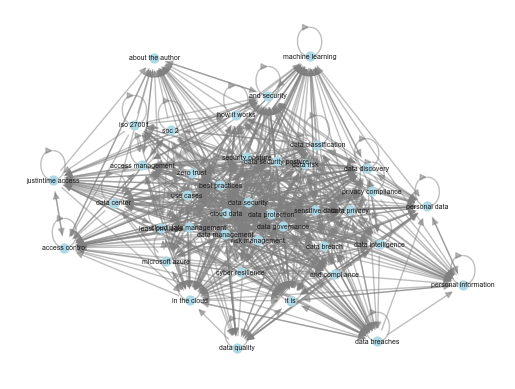

In [81]:
# visualize the graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# get the top 20 nodes with the most edges
top_nodes = [node for node in G.nodes if len(node.split(' '))>1]

# get the top 20 nodes with the most edges
top_nodes = sorted([(node, G.degree(node)) for node in top_nodes], key=lambda x: x[1], reverse=True)[:40]

# get the top 20 nodes with the most edges
top_nodes = [node for node, _ in top_nodes]

# get the subgraph of the top 20 nodes
subgraph = G.subgraph(top_nodes)

# get the positions of the nodes
pos = nx.spring_layout(subgraph)

# make the graph more spread out
for _ in range(100):
    pos = nx.spring_layout(subgraph, pos=pos, k=0.2, iterations=50)

# draw the nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=40, node_color='lightblue')

# draw the edges
nx.draw_networkx_edges(subgraph, pos, width=1, alpha=0.5, edge_color='grey')

# draw the labels
nx.draw_networkx_labels(subgraph, pos, font_size=5, font_family='sans-serif')

# show the plot
plt.axis('off')

In [27]:
import pyvis

# create a pyvis network object
pv = pyvis.network.Network(notebook=True)

# add nodes and edges to the pyvis network object
for node in G.nodes:
    pv.add_node(node, size=G.nodes[node]['pagerank']*10)

for u, v in G.edges:
    pv.add_edge(u, v, weight=G.edges[u, v]['weight'])

# show the pyvis network object
pv.show('network.html')

# close the cursor
cur.close()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/chinmayshrivastava/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gg/8p9c7n915pj7b392v8b4fxz40000gn/T/ipykernel_28955/2969223102.py", line 11, in <module>
    pv.add_edge(u, v, weight=G.edges[u, v]['weight'])
  File "/Users/chinmayshrivastava/anaconda3/lib/python3.11/site-packages/pyvis/network.py", line -1, in add_edge
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chinmayshrivastava/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chinmayshrivastava/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    retu

In [83]:
import pickle

# export the graph for later use
with open('graph.pickle', 'wb') as f:
    pickle.dump(G, f)

# close the connection
conn.close()